# Sudoku Detector

Based on Tensorflow [image segmntation tutorial](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/segmentation.ipynb)

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-bdlfcrnb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-bdlfcrnb
  Created wheel for tensorflow-examples: filename=tensorflow_examples-e3457d879907047d40c448241da8a54709bef008_-cp36-none-any.whl size=116517 sha256=59f3ad4f2d53c5c7d1704339774b7ebb9efe345e3302831caf9d1c2aed224ac1
  Stored in directory: /tmp/pip-ephem-wheel-cache-hk_8p2kz/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples
     |████████████████████████████████| 3.3MB 2.8MB/s 
  Found existing installation: tensorflow-metadata 0.21.2
    Uninstalling tensorflow-metadata-0.21.2:
      Successfully uninstalled tensorflow-metadata-0.21.2


In [2]:
!git clone https://github.com/wichtounet/sudoku_dataset.git
%cd sudoku_dataset

Cloning into 'sudoku_dataset'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 1580 (delta 1), reused 0 (delta 0), pack-reused 1574
Receiving objects: 100% (1580/1580), 494.05 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (429/429), done.
Checking out files: 100% (1021/1021), done.
/content/sudoku_dataset


In [3]:
%ls

baptiste.sh*  jean.sh*           mixed_natural/       README.rst
datasets/     mixed/             original/            tools/
images/       mixed_incomplete/  outlines_sorted.csv  wip/


In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import skimage
import imagesize

from skimage import draw, io
from tensorflow_examples.models.pix2pix import pix2pix

In [80]:
def convert_row(row):
  path = row.filepath
  polygon = [(row.p1_y, row.p1_x), (row.p2_y, row.p2_x), (row.p3_y, row.p3_x), (row.p4_y, row.p4_x)]
  return pd.Series([path, polygon], index=['path', 'polygon'])

df = pd.read_csv('outlines_sorted.csv').head(200).apply(convert_row, axis=1, result_type='expand')
df.sample(frac=1).reset_index(drop=True)

,path,polygon
0,./images/image160.jpg,"[(4, 93), (7, 545), (461, 547), (464, 86)]"
1,./images/image101.jpg,"[(12, 37), (7, 446), (436, 449), (435, 34)]"
2,./images/image178.jpg,"[(20, 204), (25, 611), (436, 617), (442, 207)]"
3,./images/image28.jpg,"[(27, 133), (35, 574), (478, 579), (477, 122)]"
4,./images/image1066.jpg,"[(351, 53), (349, 638), (945, 661), (945, 46)]"
...,...,...
195,./images/image30.jpg,"[(32, 100), (34, 584), (442, 600), (449, 92)]"
196,./images/image17.jpg,"[(2, 127), (8, 545), (441, 556), (449, 123)]"
197,./images/image96.jpg,"[(32, 17), (35, 441), (455, 449), (466, 21)]"
198,./images/image111.jpg,"[(19, 60), (17, 552), (431, 562), (445, 51)]"


In [0]:
data = df.to_records(index=False).tolist()
paths, polygons = map(list, zip(*data))

In [82]:
IMAGE_SIZE = 128

def preprocess_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 3)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  return image

def preprocess_mask(image, polygon):
  mask = np.zeros(image.shape, dtype=image.dtype)
  rr, cc = skimage.draw.polygon(polygon[:, 0], polygon[:, 1], mask.shape)
  mask[rr, cc] = 255
  return mask

@tf.function
def preprocess(path, polygon):
  image = tf.io.read_file(path)
  image = tf.io.decode_image(image, channels=3, expand_animations=False)

  #image = tf.numpy_function(preprocess_image, [image], Tout=tf.uint8)
  mask  = tf.numpy_function(preprocess_mask, [image, polygon], Tout=tf.uint8)

  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  mask  = tf.image.convert_image_dtype(mask, dtype=tf.float32)
  
  image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
  mask  = tf.image.resize_with_pad(mask, IMAGE_SIZE, IMAGE_SIZE)
  
  # image = tf.image.rgb_to_grayscale(image)
  mask = tf.image.rgb_to_grayscale(mask)

  return image, mask

dataset = tf.data.Dataset.from_tensor_slices((paths, polygons)).map(preprocess)
dataset

<MapDataset shapes: ((128, 128, None), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [0]:
def show_images(images):
  plt.figure(figsize=(15, 15))
  for index, (title, image) in enumerate(images.items()):
    plt.subplot(1, len(images), index + 1)
    plt.title(title)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
    plt.axis('off')
  plt.show()

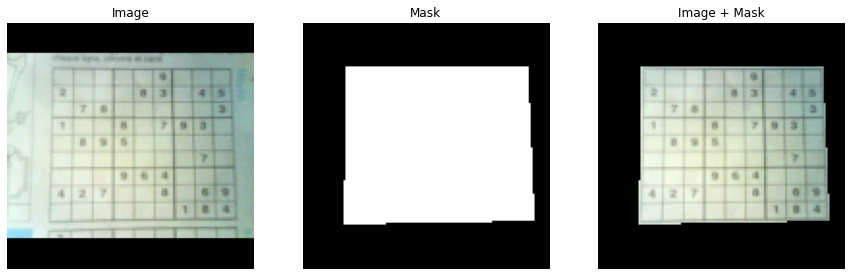

In [84]:
for image, mask in dataset.take(1):
  sample_image, sample_mask = image, mask
  show_images({'Image': image, 'Mask': mask, 'Image + Mask': np.where(mask > 0.5, image, 0)})

In [0]:
TRAIN_SIZE = 180
BATCH_SIZE = 6
BUFFER_SIZE = 90
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

In [86]:
train_dataset = dataset.take(TRAIN_SIZE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = dataset.skip(TRAIN_SIZE).batch(BATCH_SIZE)
print(f'Train dataset: {train_dataset}')
print(f'Test dataset: {test_dataset}')

Train dataset: <PrefetchDataset shapes: ((None, 128, 128, None), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
Test dataset: <BatchDataset shapes: ((None, 128, 128, None), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [0]:
OUTPUT_CHANNELS = 2

base_model = tf.keras.applications.MobileNetV2(input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [0]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Model)                 [(None, 64, 64, 96), 1841984     input_7[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 8, 8, 512)    1476608     model_5[1][4]                    
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 8, 8, 1088)   0           sequential_8[0][0]               
                                                                 model_5[1][3]              

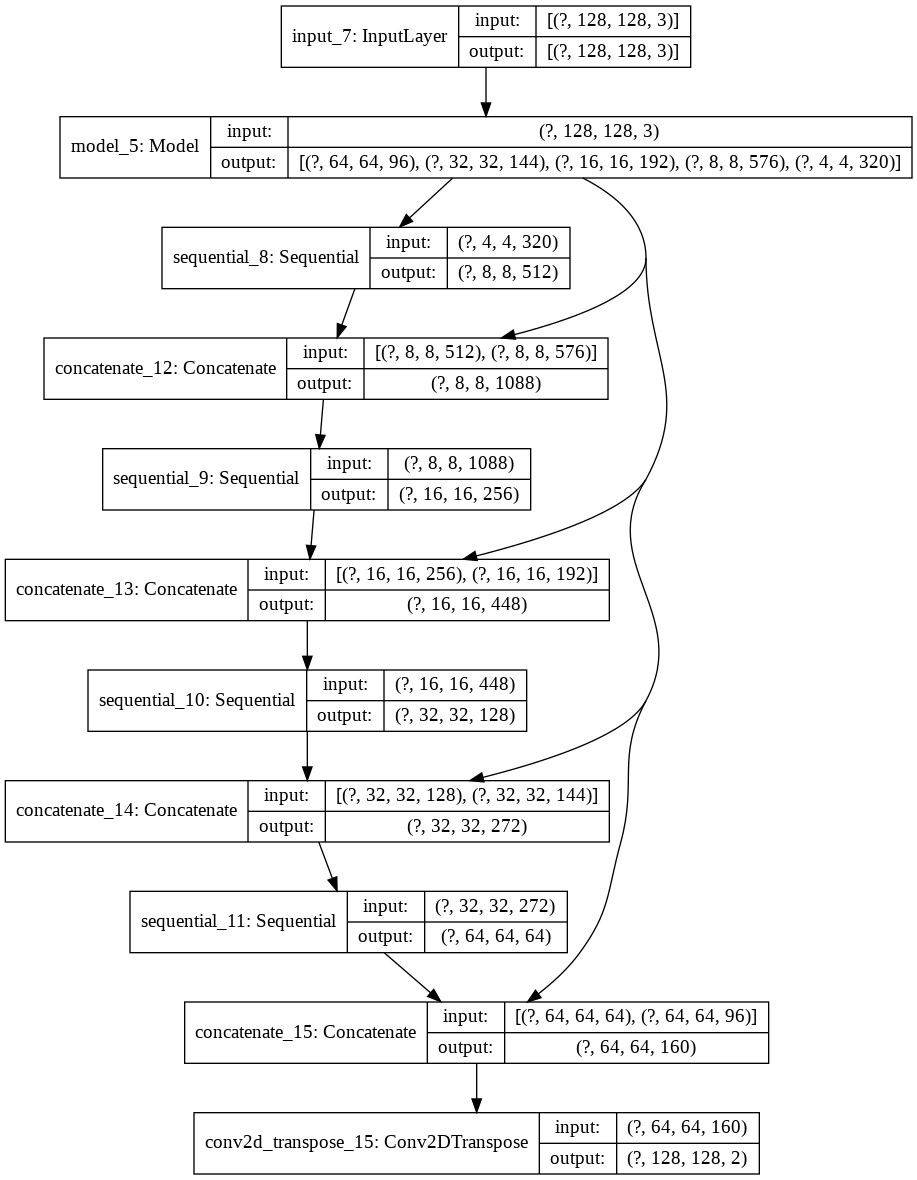

In [92]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      show_images({'Image': image[0], 'Mask': mask[0], 'Prediction': create_mask(pred_mask)})
  else:
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    show_images({'Image': sample_image, 'Mask': sample_mask, 'Prediction': create_mask(pred_mask)})

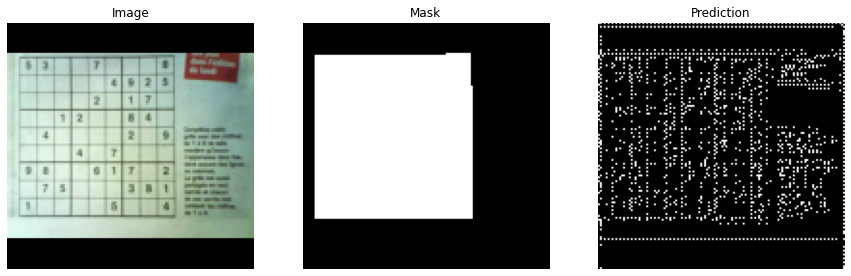

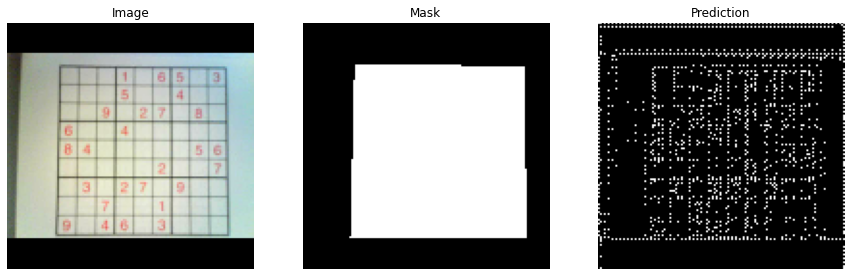

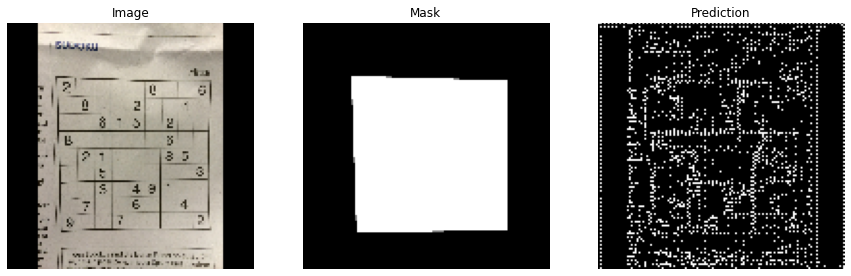

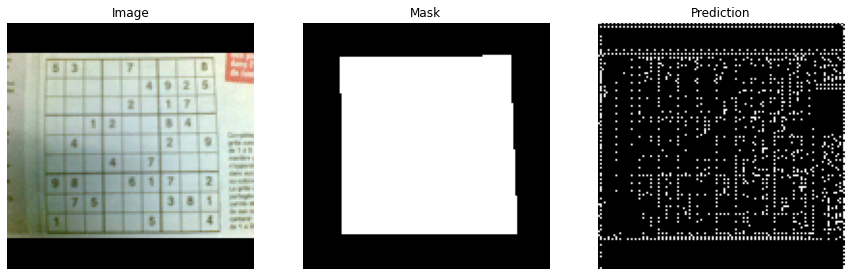

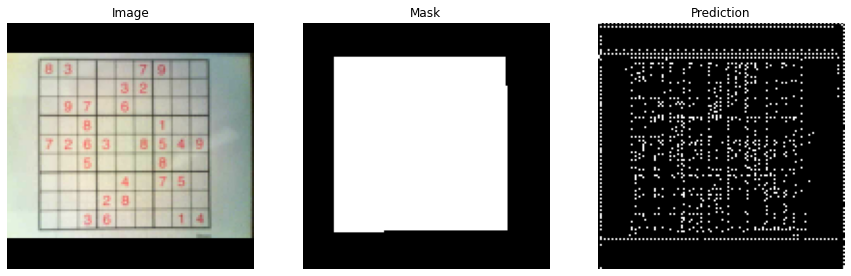

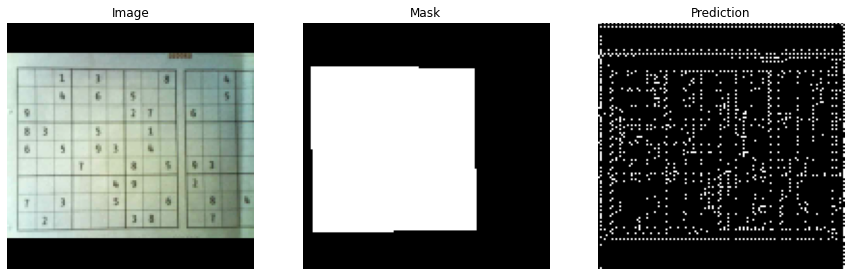

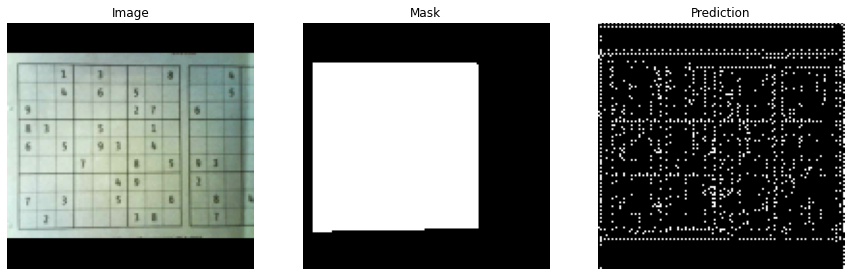

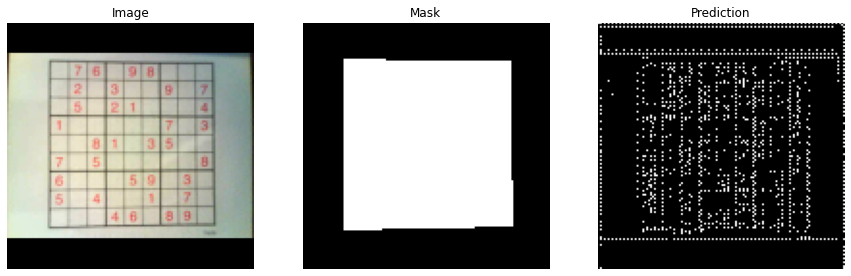

In [95]:
show_predictions(train_dataset, num=8)

In [0]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

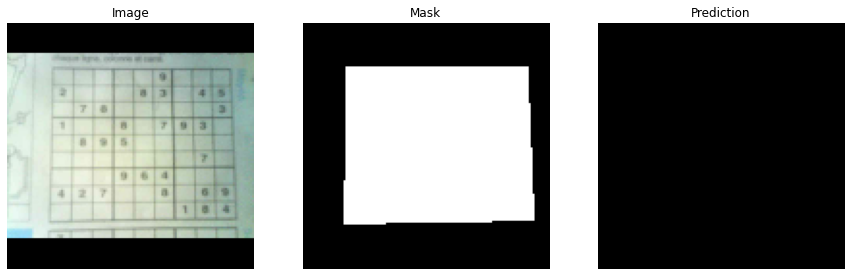


Sample Prediction after epoch 20

30/30 [==============================] - 30s 1s/step - loss: 7.4396e-05 - accuracy: 0.5422 - val_loss: 7.4660e-05 - val_accuracy: 0.5432


In [97]:
EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = (200 - TRAIN_SIZE)//BATCH_SIZE//VAL_SUBSPLITS

print(f'Train size: {TRAIN_SIZE}, test size: {200 - TRAIN_SIZE}')
print(f'BATCH_SIZE = {BATCH_SIZE}, VALIDATION_STEPS = {VALIDATION_STEPS}, STEPS_PER_EPOCH = {STEPS_PER_EPOCH}')

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

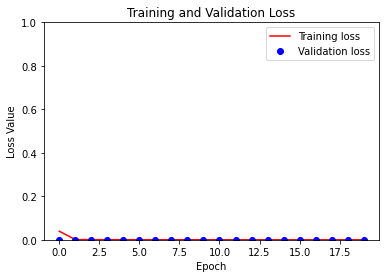

In [98]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

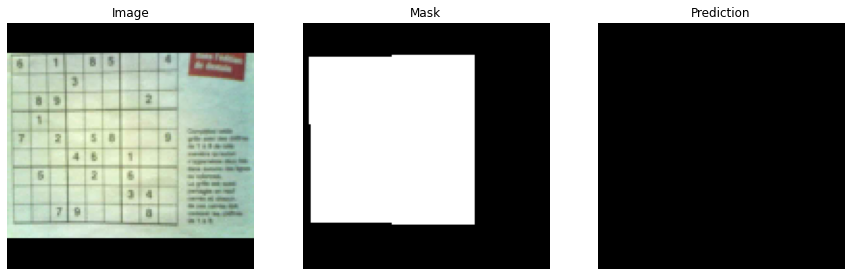

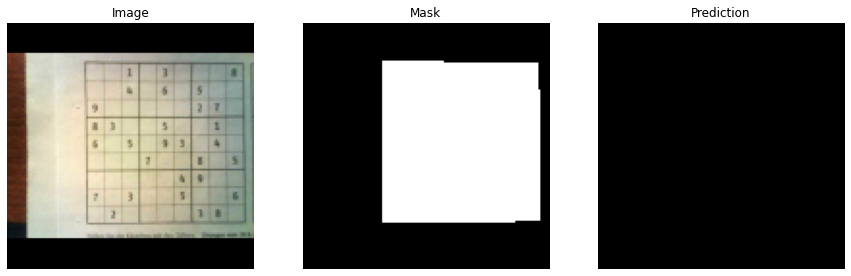

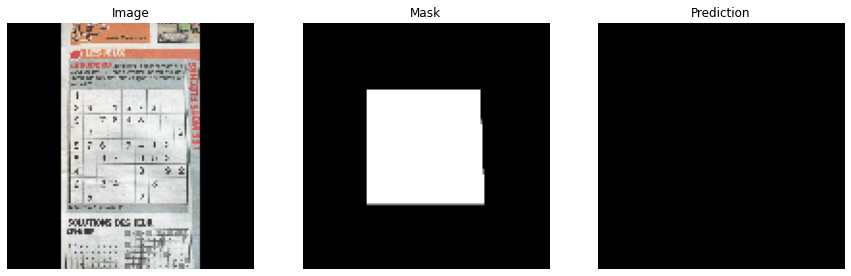

In [99]:
show_predictions(test_dataset, 3)